# This notebook is to test each component of the glm pipeline before running it for all the units.

Also good for debugging single units that are not working as expected.

---
# Setup

In [1]:
# @title imports
import sys
sys.path.append("/Users/zsombi/OneDrive/PoPy")
import os

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import xarray as xr
import numpy as np

from popy.io_tools import load_metadata
import popy.config as cfg
from popy.decoding.glms import SingleUnitAnalysis

import concurrent.futures
# mute warnings
import warnings
warnings.filterwarnings("ignore")
import time
from itertools import product
import traceback
import matplotlib.pyplot as plt

ImportError: cannot import name 'build_dataset' from 'popy.decoding.population_decoders' (/Users/zsombi/ZSOMBI/SBRI/PoPy/popy/decoding/population_decoders.py)

In [2]:
# @title helper functions
def get_all_monkey_session():
    # get all session info
    session_metadata = load_metadata()
    session_metadata = session_metadata[session_metadata['block_len_valid'] == True]  # remove session with block_len_valid==False
    monkeys = session_metadata['monkey'].values
    sessions = session_metadata['session'].values
    return monkeys, sessions

def get_grid_instances(param_grid):
    instances = []
    for current_setup in param_grid:
        # all combinations of parameters
        for grid_instance in [dict(zip(current_setup.keys(), values)) for values in product(*current_setup.values())]:  # loop over all combinations of parameters
            instances.append(grid_instance)
            
    return instances

In [3]:
# @title plotting functions
def plot_unit_avg(neural_dataset, title=None, unit_id=0):
    # plot a unit avg
    unit_avg = neural_dataset.isel(unit=unit_id)

    # plot feedback ==0 vs feedback == 1
    pos_ids = neural_dataset.feedback == 1
    neg_ids = neural_dataset.feedback == 0

    fig, axs = plt.subplots(2, 1)

    ax = axs[0]
    ax.plot(unit_avg.time, unit_avg.spike_counts[pos_ids, :].mean(dim='trial_id'), label='feedback == 1')
    ax.plot(unit_avg.time, unit_avg.spike_counts[neg_ids, :].mean(dim='trial_id'), label='feedback == 0')
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Spike count')
    ax.set_title(f'{title} spike counts')

    ax = axs[1]
    ax.plot(unit_avg.time, unit_avg.firing_rates[pos_ids, :].mean(dim='trial_id'), label='feedback == 1')
    ax.plot(unit_avg.time, unit_avg.firing_rates[neg_ids, :].mean(dim='trial_id'), label='feedback == 0')
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (Hz)')
    ax.set_title(f'{title} firing rates')

    plt.suptitle(f'unit {unit_avg.unit.values}, monkey {unit_avg.monkey.values[0]}, session {unit_avg.session.values[0]}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

---
# Section 1: init data and model

In [4]:
grid_instance =     {
        'model': 'glm_cpd',  # 'linear_correlation' or 'anova' or 'poisson_glm' or 'value_glm_CPD'
        #'glm_predictors': ['feedback', 'target'],
        'cpd_predictors': ['feedback', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6'],
        'cpd_targets': ['feedback', 'R_1', 'R_2', 'R_4', 'R_6'],
        'neural_data_type': 'spike_counts',  # 'firing_rates' or 'spike_counts'
        'value_type': 'continuous',  # 'discrete' or 'continuous'
        'step_time': .1,
    }

In [5]:
# get (monkey, session) pairs for all sessions
monkeys, sessions = get_all_monkey_session()

# pick a monkey and session
i = 0
monkey, session = 'ka', '160620'

In [6]:
# create an instance of the GLM class and set the parameters
glm = SingleUnitAnalysis(monkey, session, area='MCC')
for key, value in grid_instance.items():
    setattr(glm, key, value)


---
# Section 2: glm.run function in the pipeline

In [7]:
res, log = glm.run(print_log=True)

Running glm_cpd for ka - 160620...
0/17 - Running MCC_01_01...
1/17 - Running MCC_02_01...
2/17 - Running MCC_04_01...
3/17 - Running MCC_06_01...
4/17 - Running MCC_07_01...
5/17 - Running MCC_07_02...
6/17 - Running MCC_08_02...
7/17 - Running MCC_08_01...
8/17 - Running MCC_09_01...
9/17 - Running MCC_10_01...
10/17 - Running MCC_11_01...
11/17 - Running MCC_11_02...
12/17 - Running MCC_12_02...
13/17 - Running MCC_12_01...
14/17 - Running MCC_12_03...
15/17 - Running MCC_13_02...
16/17 - Running MCC_13_01...


In [8]:
res

<xarray.Dataset>
Dimensions:          (unit: 17, time: 56)
Coordinates:
  * unit             (unit) <U19 'ka_160620_MCC_01_01' ... 'ka_160620_MCC_13_01'
  * time             (time) float64 -2.0 -1.91 -1.82 -1.73 ... 2.77 2.86 2.95
    monkey           (unit) <U2 'ka' 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka'
    session          (unit) <U6 '160620' '160620' '160620' ... '160620' '160620'
    area             (unit) <U3 'MCC' 'MCC' 'MCC' 'MCC' ... 'MCC' 'MCC' 'MCC'
    channel          (unit) <U2 '01' '02' '04' '06' '07' ... '12' '12' '13' '13'
Data variables:
    scores           (unit, time) float64 nan nan nan nan ... nan nan nan nan
    p_vals           (unit, time) float64 nan nan nan nan ... nan nan nan nan
    coeffs_feedback  (unit, time) float64 nan nan nan ... 0.00585 0.005445
    p_vals_feedback  (unit, time) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    coeffs_R_1       (unit, time) float64 nan nan nan ... 0.0001135 0.002155
    p_vals_R_1       (unit, time) float64 nan nan nan nan ... 1.0 0.0 0.0 0.0
    coeffs_R_2       (unit, time) float64 nan nan nan ... 0.003679 0.007158
    p_vals_R_2       (unit, time) float64 nan nan nan nan ... 0.0 0.0 1.0 0.0
    coeffs_R_4       (unit, time) float64 nan nan nan ... 0.0008963 0.0008254
    p_vals_R_4       (unit, time) float64 nan nan nan nan ... 0.0 0.0 0.0 1.0
    coeffs_R_6       (unit, time) float64 nan nan nan ... 0.0009338 0.0006558
    p_vals_R_6       (unit, time) float64 nan nan nan nan ... 0.0 1.0 1.0 0.0
Attributes:
    step_time:         0.1
    area:              MCC
    glm_predictors:    [None]
    cpd_predictors:    ['feedback', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6']
    cpd_targets:       ['feedback', 'R_1', 'R_2', 'R_4', 'R_6']
    model:             glm_cpd
    neural_data_type:  spike_counts
    value_type:        continuous

In [9]:
log

[]

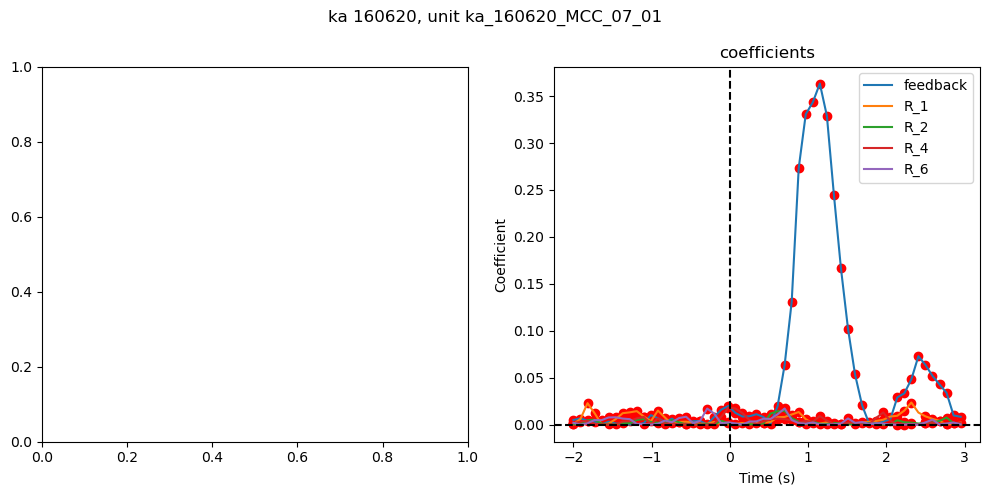

In [22]:


# plot matrix and mask insignificant values
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

example_unit = -13

# plot scores
'''ax = axs[0]
score_matrix = res.scores.data
pvals_matrix = res.p_vals.data

ax.plot(res.time, score_matrix[example_unit])
ax.scatter(res.time[pvals_matrix[example_unit] < .01], score_matrix[example_unit][pvals_matrix[example_unit] < .01], color='r')

ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title('scores')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Score')'''

# plot regressors
ax = axs[1]
for reg in [reg_ for reg_ in res.data_vars.keys() if 'coeffs' in reg_]:
    reg = reg[7:]
    score_matrix = res[f'coeffs_{reg}'].data
    pvals_matrix = res[f'p_vals_{reg}'].data
    ax.plot(res.time, score_matrix[example_unit], label=reg)
    ax.scatter(res.time[pvals_matrix[example_unit] < .01], score_matrix[example_unit][pvals_matrix[example_unit] < .01], color='r')
    
ax.legend()    
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title('coefficients')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Coefficient')

fig.suptitle(f'{monkey} {session}, unit {res.unit[example_unit].values}')
plt.tight_layout()
plt.show()
